In [31]:
%matplotlib inline
import os
import sys

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import mglearn

_Unsupervised transformations_ make datasets easier to understand then original representation. Examples are:<br>
dimensionality reduction to summarize essential characteristics.<br>
topic extraction to find topics and themes in test documents.

_Clustering algorithms_ partitions data into (unspecified) distinct groups.

## Preprocessing
1. <a href="#pca">Principal Compenent Analysis</a>
2. <a href="#nmf">Non-negative Matrix Factorization<a>
3. <a href="#sne">t-SNE</a>

### Principal Component Analysis <a id="pca"></a>
_PCA_ rotates high dimensional dataset and drops components with low variance (to denoise data).<br>
Most commonly applied to visualizing high-dim data to **capture main interactions between features**.<br>
The downside is the tranformed plot is not easy to interpret.

Steps:<br>
1. Find direction of maximum variance (called Component 1) contains most info.<br>
2. Find orthoganal direction of most variance (Compenent 2). 1 and 2 are called _Principal Components_.<br>
3. a. Mean is subtracted, so data is centered on zero.<br> 
b. The data is rotated so the first component aligns w/ x-axis and the second compnent aligns w/ y-axis. Axes are uncorrelated<br>
4. Drop the second (_nth_) _Principal compnent_ for a 1D dataset.<br>
5. Un-rotate by adding the mean, which de-noises the dataset.

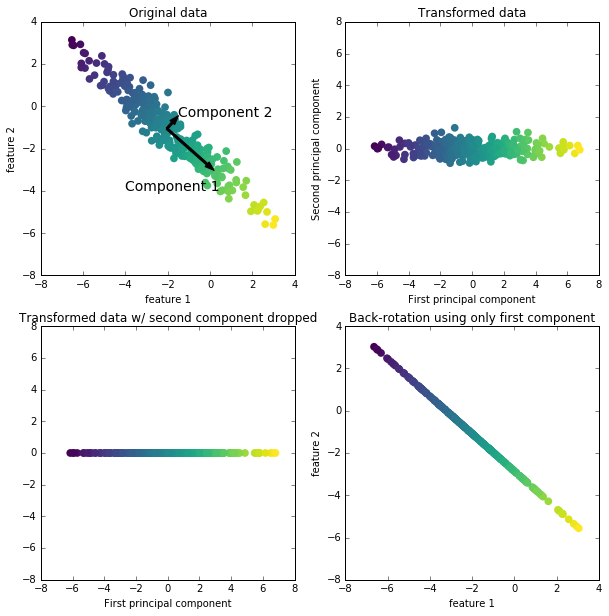

In [2]:
mglearn.plots.plot_pca_illustration()

When you can't pair plot the dataset efficiently, but we can use histograms to see:<br>
feature distribution based on binning<br>
informative features are disjointed.

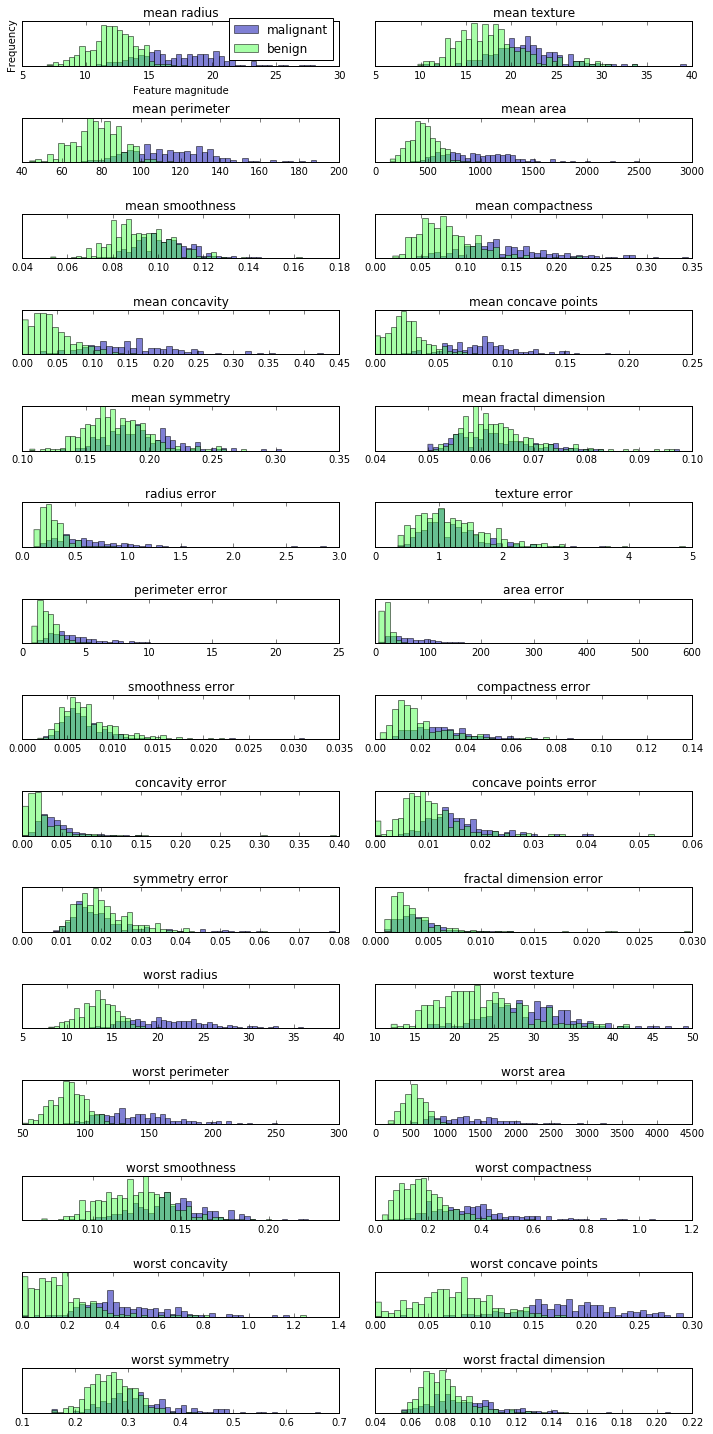

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

Scale data so each feature has unit variance of _StandardScaler_.

In [8]:
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [9]:
from sklearn.decomposition import PCA
# instantiate PCA object to keep first 2 principal compnenets.
pca = PCA(n_components=2)
# fit PCA model
pca.fit(X_scaled)

# transform the data onto the first two compnenets (top right subplot)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


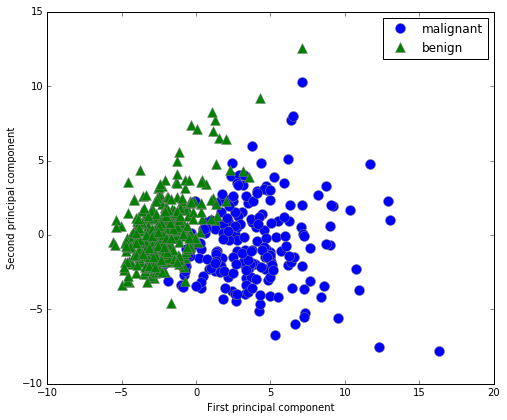

In [15]:
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best", numpoints=1)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

two classes separate well, so a linear classifier model could work.

In [16]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


each row corresponds to one principal component, and each column corresponds with the original feature:

In [20]:
cancer.feature_names[:5]

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness'], 
      dtype='<U23')

In [17]:
print("PCA component:\n{}".format(pca.components_))

PCA component:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


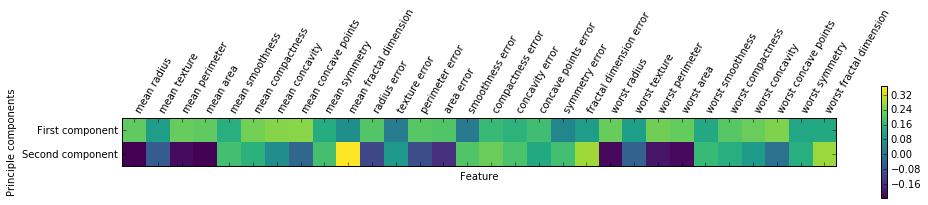

In [21]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principle components")

The First component is all neg sign (one direction), suggesting gerenal correlation between all 30 features.

### Using PCA -- Eigenfaces for feature extraction
Remember _feature extraction_ is finding a better representation of our data than the raw.

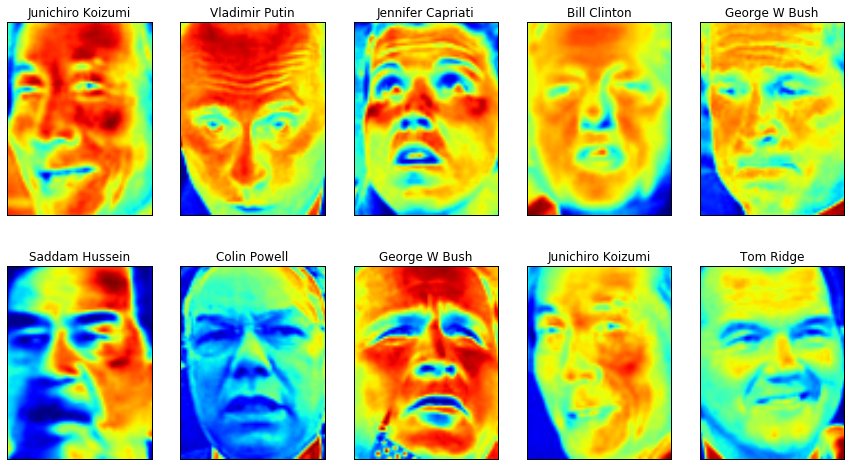

In [24]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [26]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (2244, 87, 65)
Number of classes: 35


Note each image is 87 x 65 pixels so each feature is a pixel.<br>
Too many G.W.s and Powells:

In [27]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the greyscale values to between 0 and 1
# instad of 0 to 255 for better numeric stability.
X_people = X_people / 255.

How to we work with a small training set and new faces?<br>
Using a one-nearest neighbor classifier for a similar face.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.32


Rather than looking at the distance between pixels (which change a lot!)<br>
Let's look at the greyscale value of each pixel, and the distance between principle components.<br>
_whitening_ rescales principle components to the same scale. Just like StandardScaler after transformation.

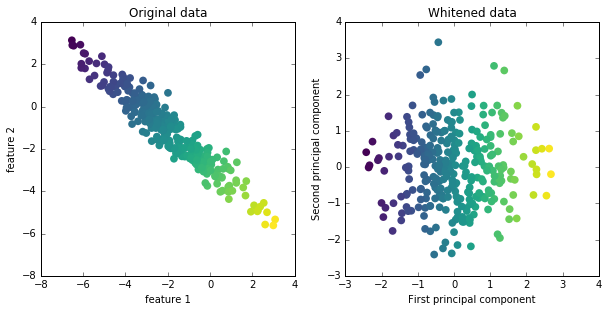

In [33]:
mglearn.plots.plot_pca_whitening()

In [34]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape

(978, 100)

New data has first 100 principle components.

In [35]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.39


Principal componeents are directions in input space -- 50x27 pixel images.

In [36]:
pca.components_.shape

(100, 5655)

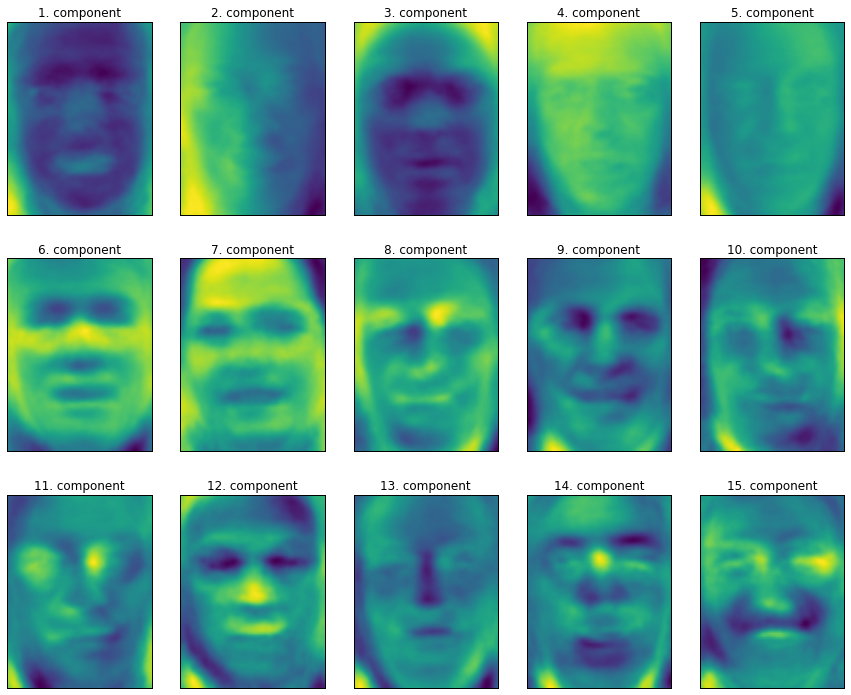

In [38]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
        ax.imshow(component.reshape(image_shape),
            cmap='viridis')
        ax.set_title("{}. component".format(i + 1))

Rotated faces to x and y axis and dropped components with low variance.<br>
Let's get a weighted sum of PCs.

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[ 0.062745, ...,  0.230065],
       ..., 
       [ 0.29281 , ...,  0.866667]], dtype=float32), 
array([[ 0.130719, ...,  0.464052],
       ..., 
       [ 0.31634 , ...,  0.007843]], dtype=float32))
_______________________________________________________pca_faces - 11.0s, 0.2min


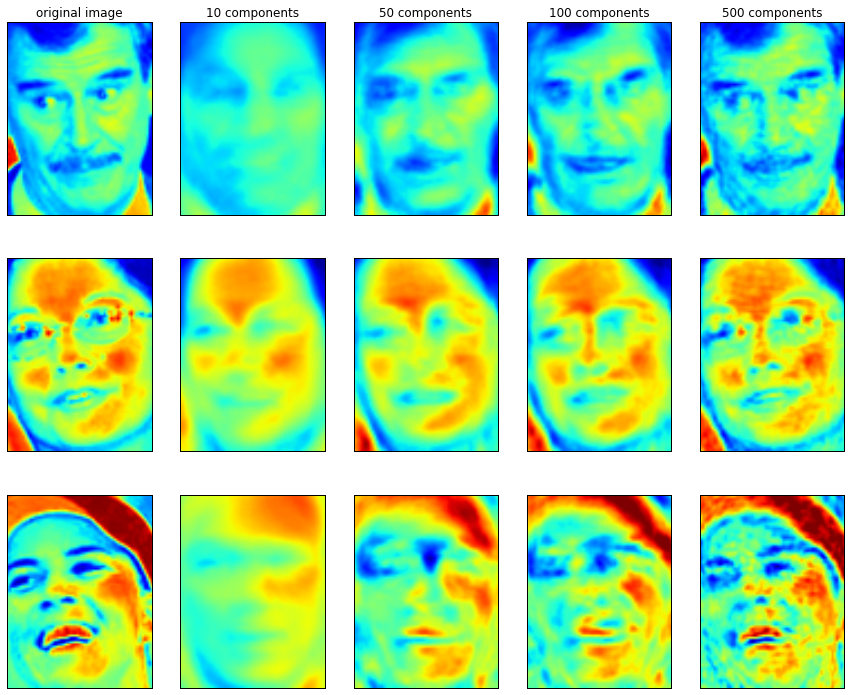

In [39]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

###  Non-negative Matrix Factorization<a id="nmf"></a>

### t-SNE<a id="sne"></a>